In [111]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge



from sklearn.linear_model import LassoCV, Lasso
import numpy as np
from sklearn.datasets import make_regression



from csv_reader import *
from csv_setup import *

In [112]:
bike_sharing_df = get_bike_sharing_df_clean()
bike_sharing_df.columns


print(bike_sharing_df.columns)


Index(['hr', 'holiday', 'workingday', 'weathersit', 'atemp', 'hum',
       'windspeed', 'cnt', 'no_snow', 'medium_snow', 'heavy_snow'],
      dtype='object')


7445     109
13512      6
6158       8
13205    175
1616      86
        ... 
10955    537
17289     51
5192     101
12172    270
235        3
Name: cnt, Length: 11643, dtype: int64


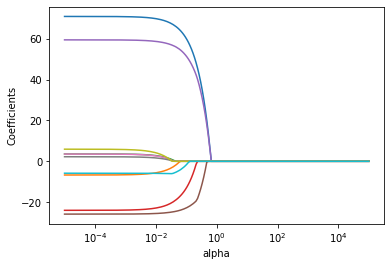

In [132]:



Y = bike_sharing_df.cnt
X = bike_sharing_df.loc[:].drop(columns=["cnt"])




X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 1)
print(y_train)

n_folds = 10
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas) #grid search for lambda (aka 'alpha')

parameters = { 'lasso__alpha':alphas}

scaler = StandardScaler()
lasso = Lasso(normalize=True,tol=2,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)

gs = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
gs.fit(X_train,y_train)

alphas = np.logspace(-5, 5, n_alphas) #grid search for lambda (aka 'alpha')

coefs = []
# print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)
parameters = {'lasso__alpha':alphas}
# model = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
# model.fit(X_train,y_train)
for a in alphas:
    pipe.set_params(lasso__alpha=a)
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure()
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients');


# plt.figure()
# ax = plt.gca()
# ax.plot(alphas, coefs,'o')
# ax.set_xscale('log')
#
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('Coefficients')
# plt.title('Zoomed in')
# plt.xlim(.01,100)


In [133]:
# coefficients {𝛽1,…,𝛽𝑝} for the last fitted model in the above for loop
pipe.named_steps['lasso'].coef_

array([ 0., -0.,  0., -0.,  0., -0.,  0.,  0., -0., -0.])

In [134]:
# B0
pipe.named_steps['lasso'].intercept_

188.19144550373616

In [135]:
# Average of Y's
np.mean(y_train)

188.19144550373616

In [136]:
# Best alpha
best_alpha = gs.best_params_['lasso__alpha']
print(best_alpha)

0.08309941949353396


In [137]:
scaler = StandardScaler()
lasso = Lasso(alpha=best_alpha,normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)
pipe.fit(X_train, y_train)

best_coef_lasso = pipe.named_steps['lasso'].coef_

# print('The final set of coefficients: ')
print(best_coef_lasso)

[ 52.24227059  -4.21419196   1.63022268  -0.60766097  52.62030134
 -42.56584069   1.79189654   4.84028503  -0.         -12.33696008]


In [140]:
print('\nCoefficients  [lasso]')
for i in range(0,10):
    print('   Feature %2i:  %.2f'%(i,\
                    best_coef_lasso[i]))


Coefficients  [lasso]
   Feature  0:  52.24
   Feature  1:  -4.21
   Feature  2:  1.63
   Feature  3:  -0.61
   Feature  4:  52.62
   Feature  5:  -42.57
   Feature  6:  1.79
   Feature  7:  4.84
   Feature  8:  -0.00
   Feature  9:  -12.34


In [141]:
np.count_nonzero(best_coef_lasso)

9

In [142]:
y_pred = pipe.predict(x_test)
mse_test_using_lasso = mean_squared_error(y_test,y_pred)
# print(mse_test_using_coef_true)
print('\nTest set MSE using Lasso coefficients: %.2f'%mse_test_using_lasso)
np.set_printoptions(threshold=np.inf)



Test set MSE using Lasso coefficients: 22840.36


In [146]:

lm = pipe



y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)

print('Train Score: ')
print(r2_score(y_train, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test, y_test_pred))

Train Score: 
0.33007952248513583

Test Score: 
0.33117176844572527
